In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read in datasets
ent_2015 = pd.read_csv("data/2015_entities.txt", encoding='latin-1')
data_2015 = pd.read_csv("data/2015_research.txt")

ent_2016 = pd.read_csv("data/2016_entities.txt", encoding='latin-1')
data_2016 = pd.read_csv("data/2016_research.txt")

ent_2017 = pd.read_csv("data/2017_entities.txt", encoding='latin-1')
data_2017 = pd.read_csv("data/2017_research.txt")

ent_2018 = pd.read_csv("data/2018_entities.txt", encoding='latin-1')
data_2018 = pd.read_csv("data/2018_research.txt")

In [3]:
# merge entities and datasets per year
all_data_15 = data_2015.merge(ent_2015, how="left")
all_data_16 = data_2016.merge(ent_2016, how="left")
all_data_17 = data_2017.merge(ent_2017, how="left")
all_data_18 = data_2018.merge(ent_2018, how="left")

In [4]:
# only keep certain columns and convert character columns to numeric
def tidy_data(df):
    keep_schools = ['Berkeley High','Martin Luther King Middle', 'Willard Middle',
       'Rosa Parks Environmental Science', 'Cragmont Elementary', 'Rosa Parks Environmental Science Magnet',
                    'Emerson Elementary', 'Jefferson Elementary',
                    'Sylvia Mendez Elementary', 'Malcolm X Elementary',
                    'Longfellow Arts And Technology Middle', 'Oxford Elementary',
                    'Thousand Oaks Elementary', 'Washington Elementary',
                    'John Muir Elementary', 'Berkeley Arts Magnet At Whittier']
    
    new = df.loc[(df['Type Id'] == 7) & (df['School Name'].isin(keep_schools)), :].copy()
    new = new.replace('Rosa Parks Environmental Science Magnet', 'Rosa Parks Environmental Science')
    
    keep_cols = ['School Code', 'Test Year','Subgroup ID', 'Grade',
             'Test Id', 'CAASPP Reported Enrollment', 'Students Tested',
             'Mean Scale Score','School Name', 'Zip Code', 'Not Met', 'Met']
    
    new = new.loc[((new['Grade'] == 11) & (new['School Name'] == 'Berkeley High')) | (new['Grade'] != 11), :]
    
    new['Not Met'] = pd.to_numeric(df['Percentage Standard Nearly Met'], errors='coerce') + pd.to_numeric(df['Percentage Standard Not Met'], errors='coerce')
    new['Met'] = pd.to_numeric(df['Percentage Standard Met and Above'], errors='coerce')
    new['Students Tested'] = pd.to_numeric(new['Students Tested'], errors='coerce')
    new['Mean Scale Score'] = pd.to_numeric(df['Mean Scale Score'], errors='coerce')
    
    return new[keep_cols]

In [5]:
# stored cleaned datasets for each year
dat_15 = tidy_data(all_data_15)
dat_16 = tidy_data(all_data_16)
dat_17 = tidy_data(all_data_17)
dat_18 = tidy_data(all_data_18)

In [6]:
# store all years' data into single dataframe
df = pd.concat([dat_15, dat_16, dat_17, dat_18], sort=False)
df.head()

,School Code,Test Year,Subgroup ID,Grade,Test Id,CAASPP Reported Enrollment,Students Tested,Mean Scale Score,School Name,Zip Code,Not Met,Met
1158,131177,2015,1,11,2,807,685.0,2602.3,Berkeley High,94704,56.0,44.0
1159,131177,2015,1,11,1,807,698.0,2625.3,Berkeley High,94704,33.0,67.0
1160,131177,2015,1,13,1,807,698.0,NaN,Berkeley High,94704,33.0,67.0
1161,131177,2015,1,13,2,807,685.0,NaN,Berkeley High,94704,56.0,44.0
1162,131177,2015,3,11,1,807,363.0,2614.8,Berkeley High,94704,36.0,64.0


# Preliminary Analysis

#### a) Filter % Met/Exceeded by Subject, Grade, Gender

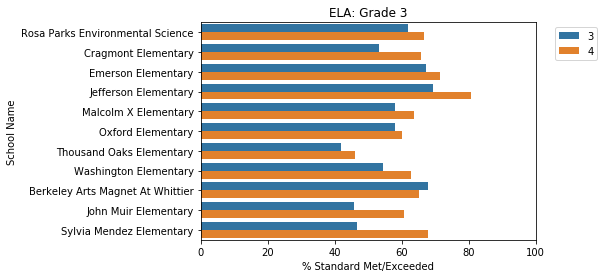

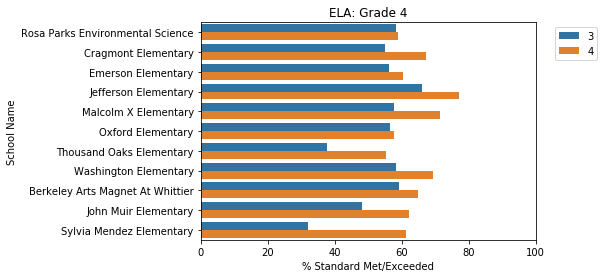

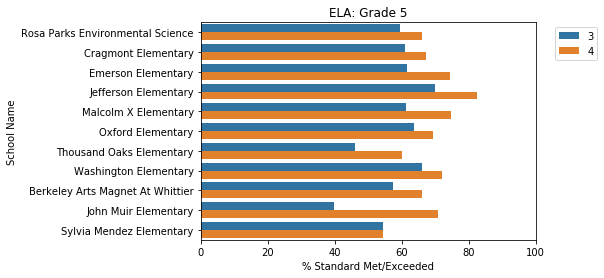

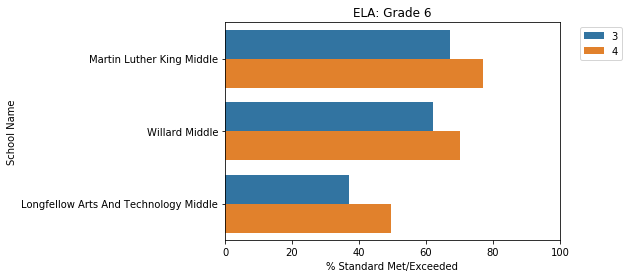

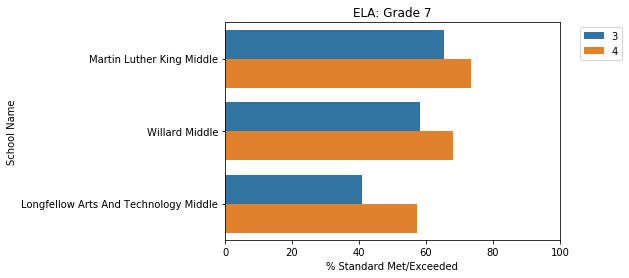

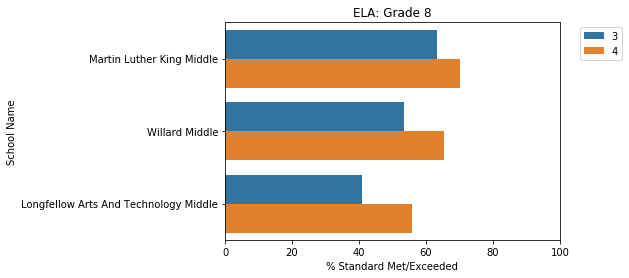

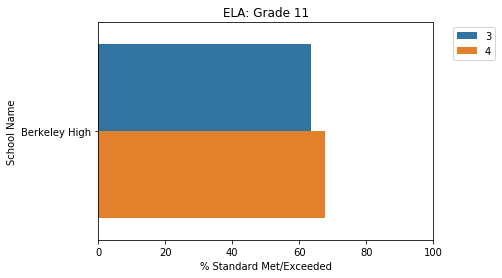

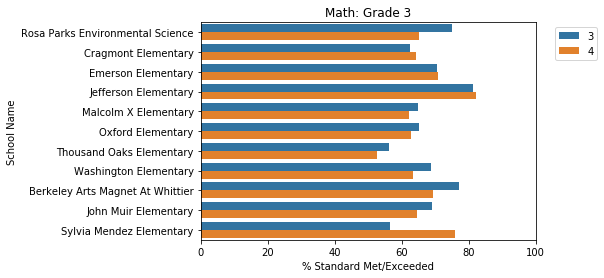

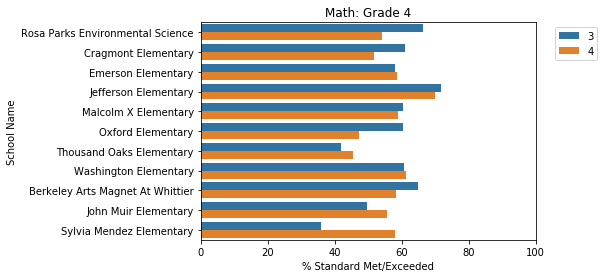

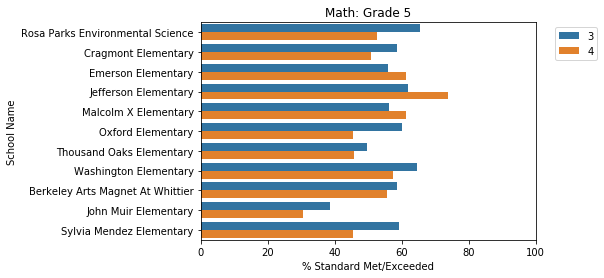

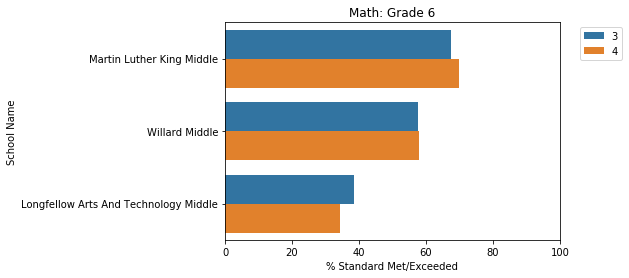

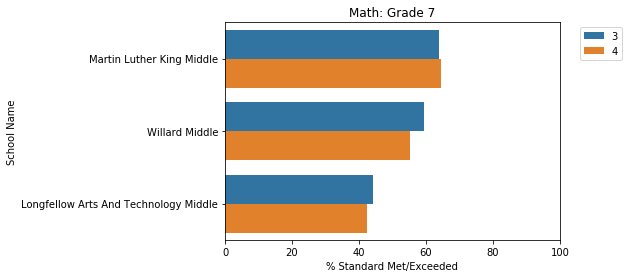

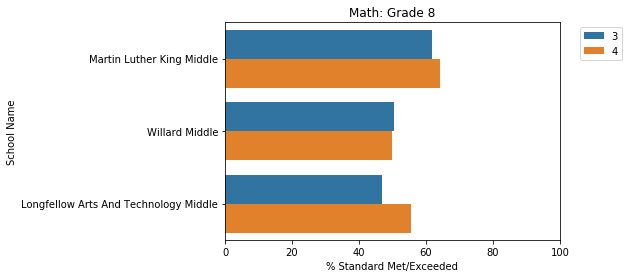

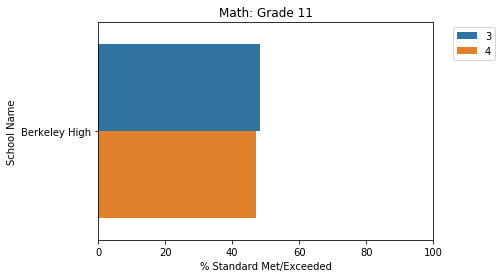

In [118]:
# create dataframe separated by gender
gender = df.loc[df['Subgroup ID'].isin([3,4]), :]
grades = [3,4,5,6,7,8,11]
subjects = [1, 2]

for s in subjects:
    for g in grades:
        plt.figure()
        sns.barplot(x='Met', y='School Name', hue='Subgroup ID',
                   data = gender.loc[(gender['Test Id'] == s) & (gender['Grade'] == g), :], ci=False)
        if s == 1:
            plt.title(f"ELA: Grade {g}")
        else:
            plt.title(f"Math: Grade {g}")
        plt.xlabel("% Standard Met/Exceeded")
        plt.xlim(0, 100)
        plt.legend(bbox_to_anchor=(1.2, 1));

#### b) Filter % Met/Exceeded by Subject, Grade, Economic Status

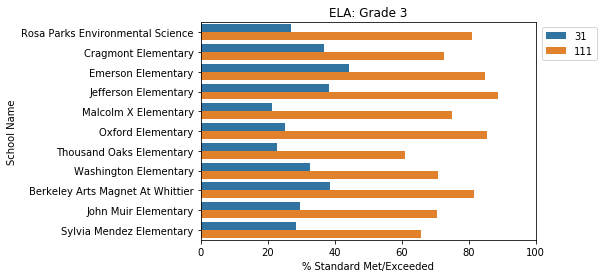

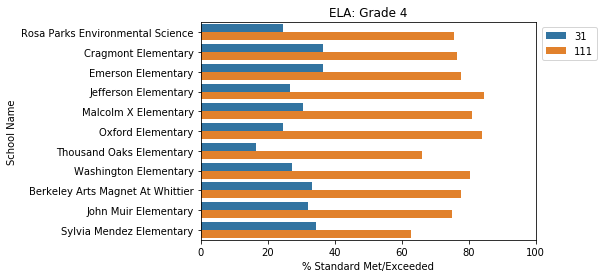

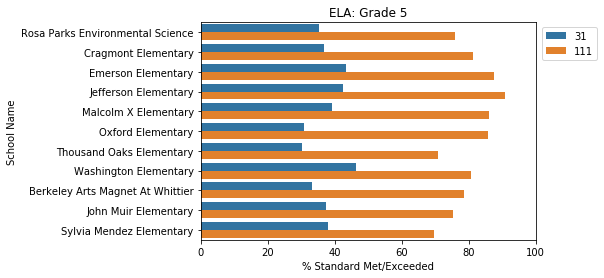

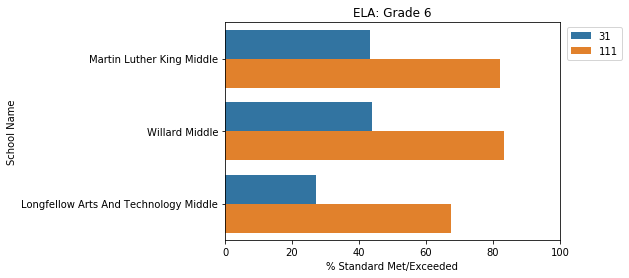

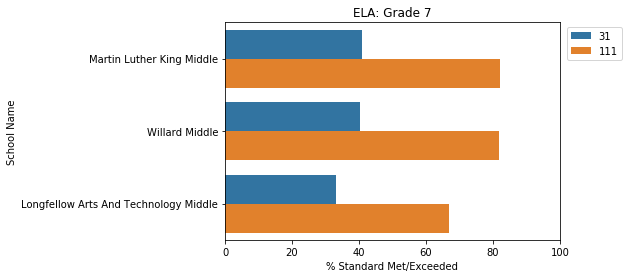

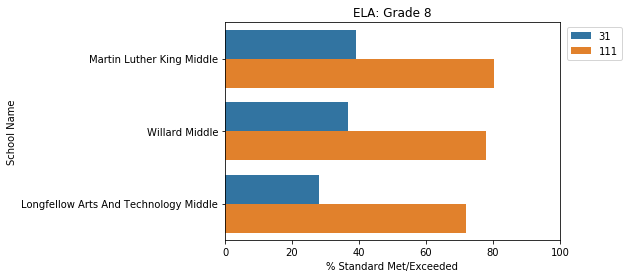

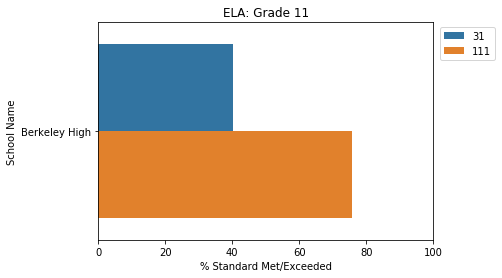

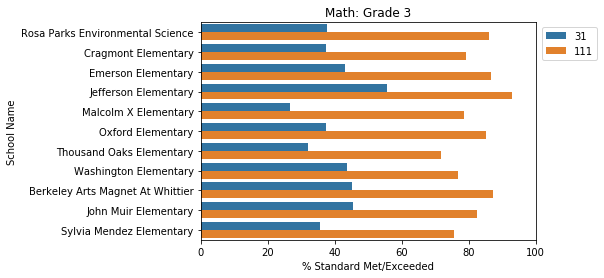

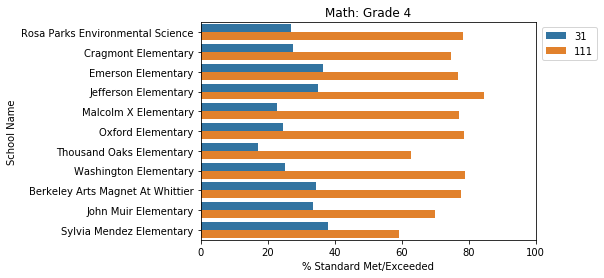

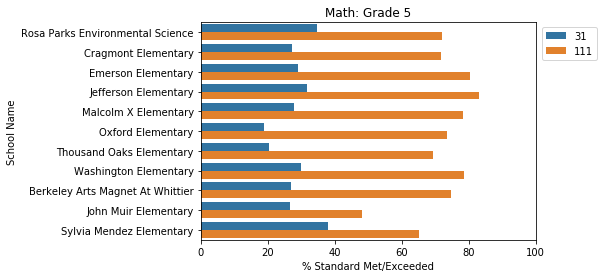

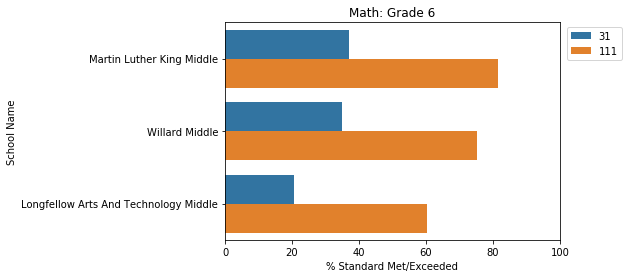

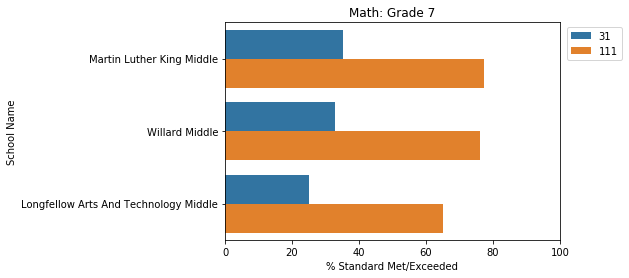

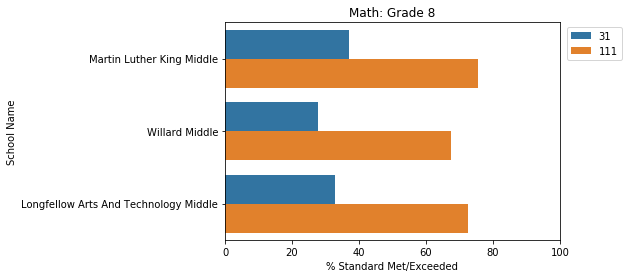

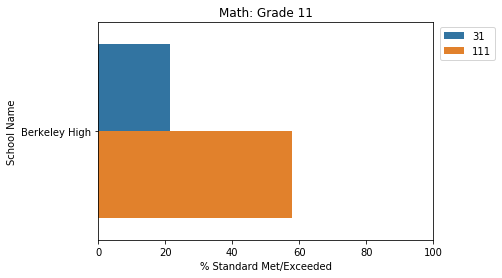

In [17]:
# create dataframe separated by economic status
econ = df.loc[df['Subgroup ID'].isin([31, 111]), :]
grades = [3,4,5,6,7,8,11]
subjects = [1, 2]

for s in subjects:
    for g in grades:
        plt.figure()
        sns.barplot(x='Met', y='School Name', hue='Subgroup ID',
                   data = econ.loc[(econ['Test Id'] == s) & (econ['Grade'] == g), :], ci=False)
        if s == 1:
            plt.title(f"ELA: Grade {g}")
        else:
            plt.title(f"Math: Grade {g}")
        plt.xlabel("% Standard Met/Exceeded")
        plt.xlim(0, 100)
        plt.legend(bbox_to_anchor=(1.2, 1));

#### c) % Met/Exceeded from 2015-2018 by School and Subject

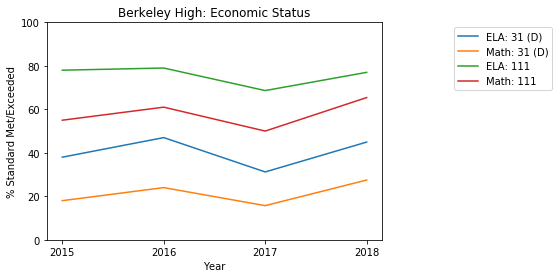

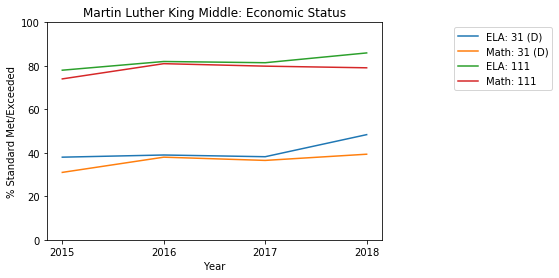

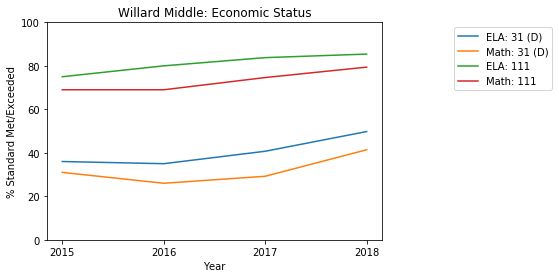

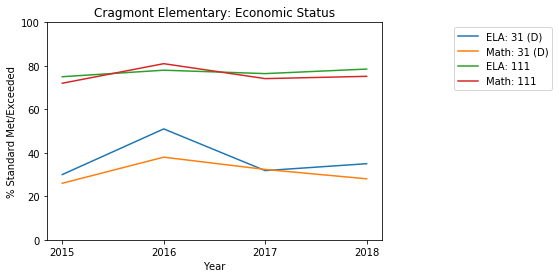

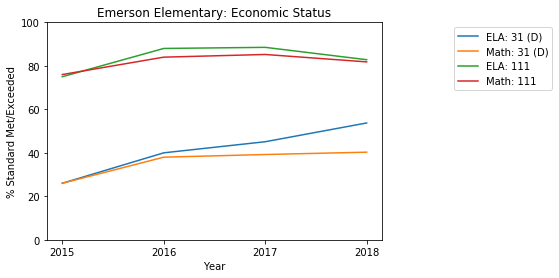

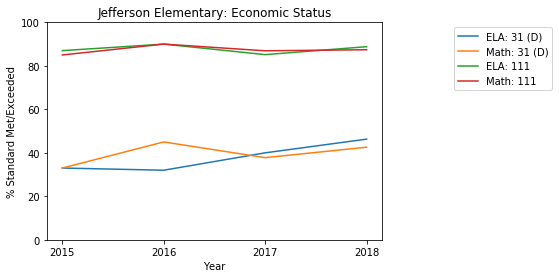

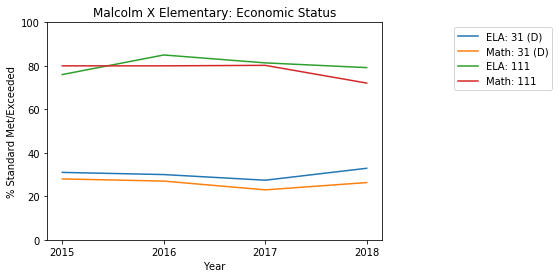

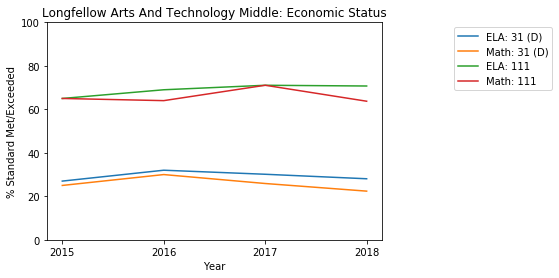

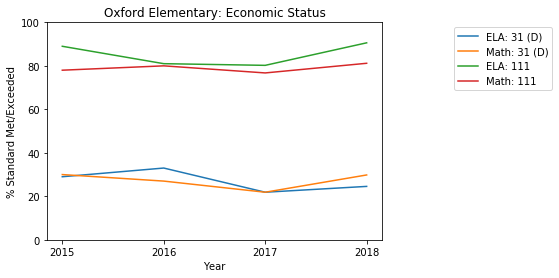

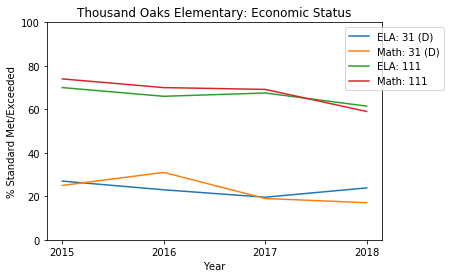

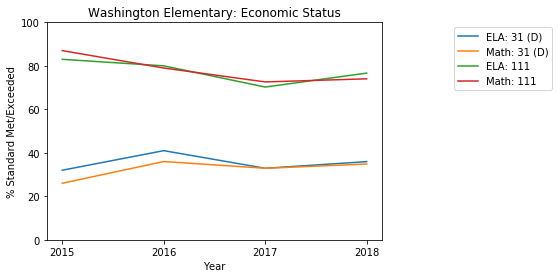

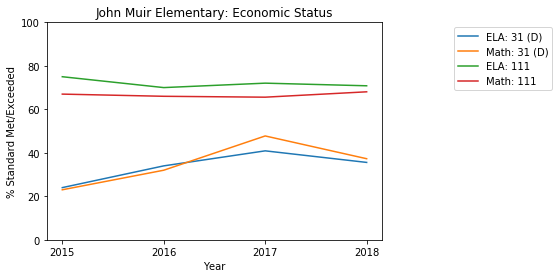

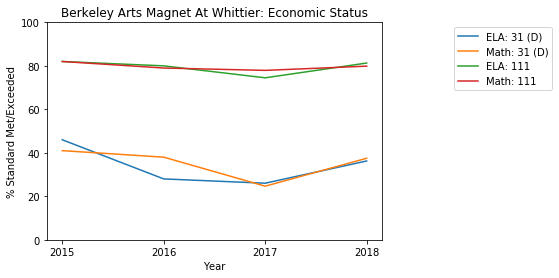

In [18]:
# excludes Rosa Parks, Sylvia Mendez (only 2018 data available)
econ = df.loc[df['Subgroup ID'].isin([31, 111]), :]
schools = ['Berkeley High','Martin Luther King Middle', 'Willard Middle', 'Cragmont Elementary',
                    'Emerson Elementary', 'Jefferson Elementary', 'Malcolm X Elementary',
                    'Longfellow Arts And Technology Middle', 'Oxford Elementary',
                    'Thousand Oaks Elementary', 'Washington Elementary',
                    'John Muir Elementary', 'Berkeley Arts Magnet At Whittier']

for s in schools:
    plt.figure()
    sns.lineplot(x='Test Year', y='Met',
                     data = econ.loc[(econ['School Name']==s) & 
                                     (econ['Subgroup ID'] == 31) & 
                                     (econ['Test Id'] == 1) &
                                     (econ['Grade'] == 13), :],
                     label = f'ELA: 31 (D)', ci=False)
    sns.lineplot(x='Test Year', y='Met',
                     data = econ.loc[(econ['School Name']==s) & 
                                     (econ['Subgroup ID'] == 31) & 
                                     (econ['Test Id'] == 2) & 
                                     (econ['Grade'] == 13), :],
                     label = f'Math: 31 (D)', ci=False)
    sns.lineplot(x='Test Year', y='Met',
                     data = econ.loc[(econ['School Name']==s) & 
                                     (econ['Subgroup ID'] == 111) & 
                                     (econ['Test Id'] == 1) & 
                                     (econ['Grade'] == 13), :],
                     label = f'ELA: 111', ci=False)
    sns.lineplot(x='Test Year', y='Met',
                     data = econ.loc[(econ['School Name']==s) & 
                                     (econ['Subgroup ID'] == 111) & 
                                     (econ['Test Id'] == 2) & 
                                     (econ['Grade'] == 13), :],
                     label = f'Math: 111', ci=False)
    plt.title(f"{s}: Economic Status")
    plt.xticks(np.arange(2015, 2019, 1))
    plt.xlabel("Year")
    plt.ylabel("% Standard Met/Exceeded")
    plt.ylim(0, 100)
    plt.legend(bbox_to_anchor=(1.2, 1));

#### d) Ethnic Balance by School

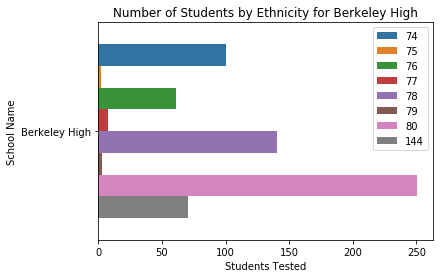

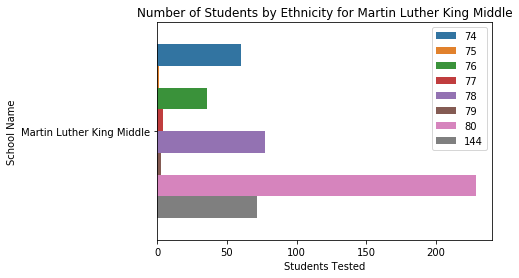

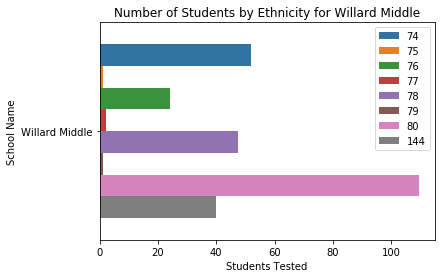

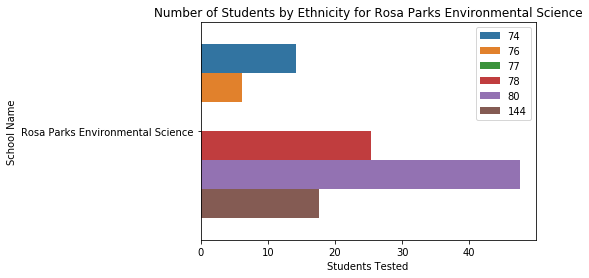

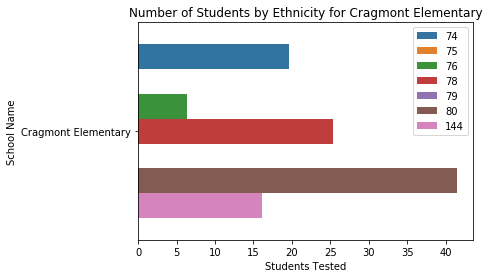

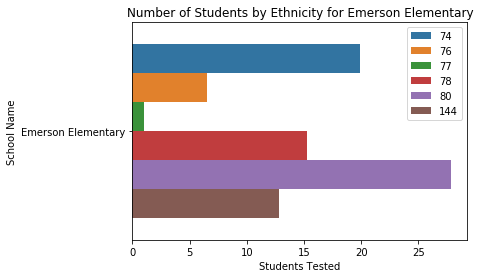

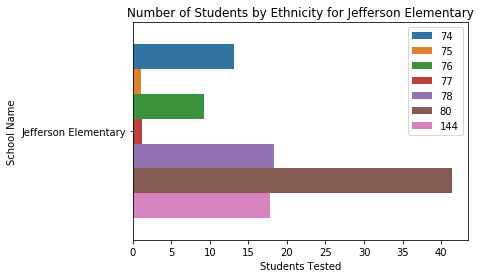

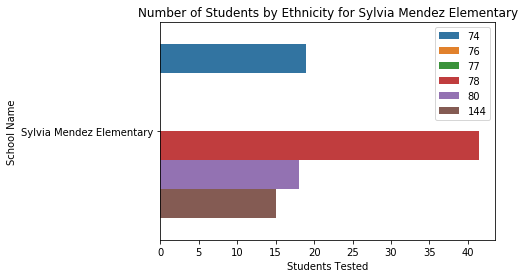

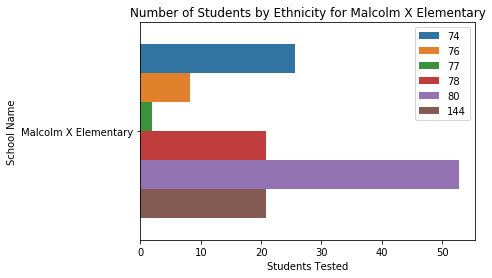

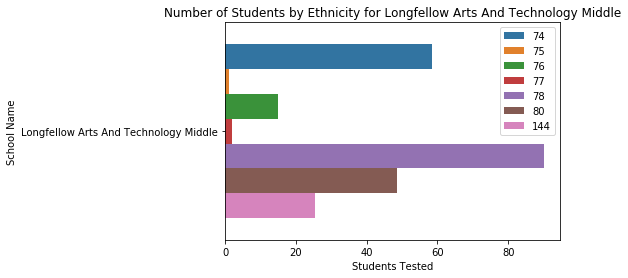

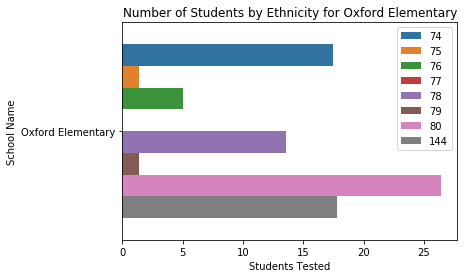

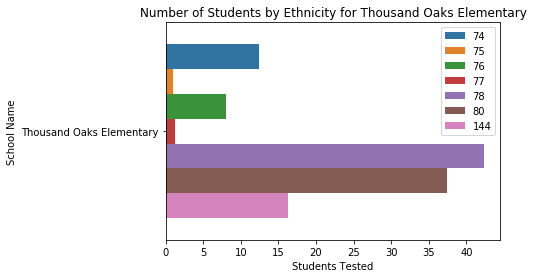

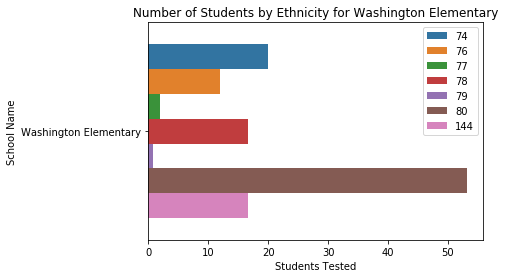

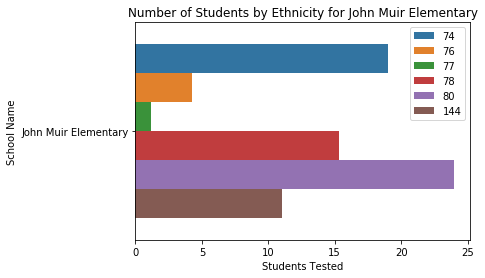

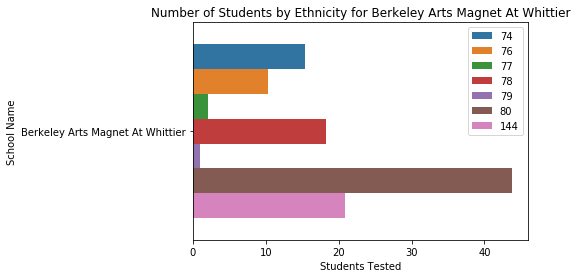

In [19]:
grps = [74, 75, 76, 77, 78, 79, 80, 144]
schools = ['Berkeley High','Martin Luther King Middle', 'Willard Middle',
           'Rosa Parks Environmental Science', 'Cragmont Elementary', 'Emerson Elementary',
           'Jefferson Elementary','Sylvia Mendez Elementary', 'Malcolm X Elementary',
           'Longfellow Arts And Technology Middle', 'Oxford Elementary',
           'Thousand Oaks Elementary', 'Washington Elementary','John Muir Elementary', 'Berkeley Arts Magnet At Whittier']

for s in schools:
    plt.figure()
    sns.barplot(x='Students Tested', y='School Name', hue='Subgroup ID', ci=False,
                data = df.loc[(df['Subgroup ID'].isin(grps)) & (df['School Name'] == s), :])
    plt.title(f"Number of Students by Ethnicity for {s}")
    plt.legend(loc='upper right');

# Cohort Analysis

- Cohort 1: Grade 3 (2015), Grade 4 (2016), Grade 5 (2017)

- Cohort 2: Grade 3 (2016), Grade 4 (2017), Grade 5 (2018)

In [20]:
# list of elementary school names (excluding Sylvia Mendez - only 2018 data available)
elem_names = ['Rosa Parks Environmental Science', 'Cragmont Elementary','Emerson Elementary',
        'Jefferson Elementary', 'Malcolm X Elementary',
        'Oxford Elementary', 'Thousand Oaks Elementary', 'Washington Elementary',
        'John Muir Elementary']

### 1. Cohorts by School, Test ID

In [21]:
# ALL STUDENTS
elem = df.loc[(df['School Name'].isin(elem_names)) & (df['Subgroup ID'] == 1) & (df['Grade'].isin([3,4,5])), :]

# both cohorts
grp1 = ((elem['Test Year']==2015)&(elem['Grade']==3)) | ((elem['Test Year']==2016)&(elem['Grade']==4)) | ((elem['Test Year']==2017)&(elem['Grade']==5))
grp2 = ((elem['Test Year']==2016)&(elem['Grade']==3)) | ((elem['Test Year']==2017)&(elem['Grade']==4)) | ((elem['Test Year']==2018)&(elem['Grade']==5))



#### 1a) Cohort 1 (2015-2017) by School, Test ID

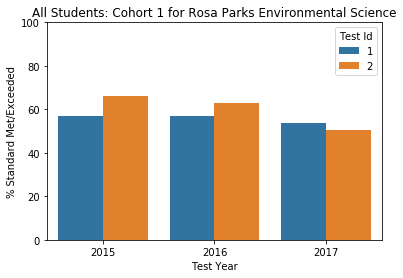

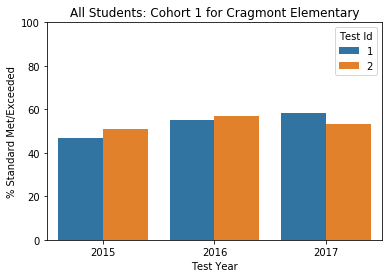

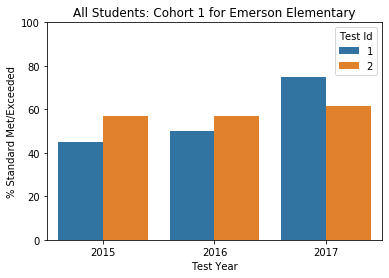

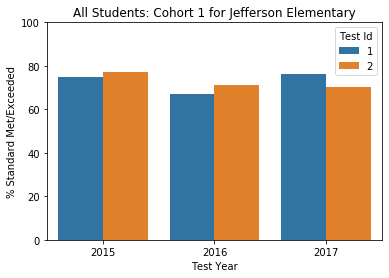

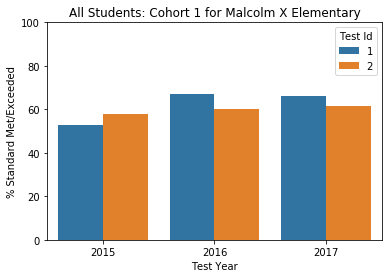

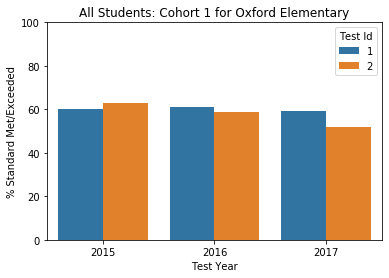

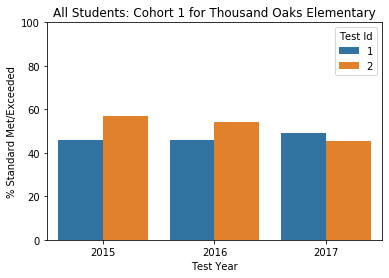

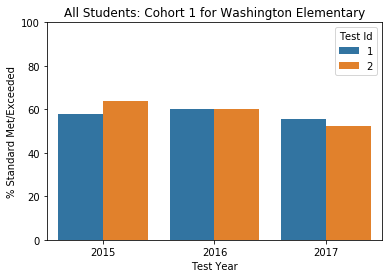

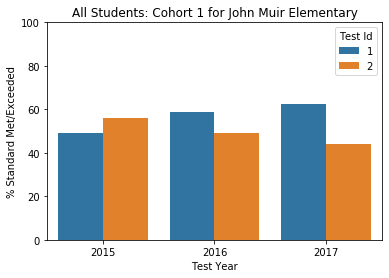

In [22]:
for s in elem_names:
    plt.figure()
    dat = elem.loc[(elem['School Name'] == s) & grp1, :]
    sns.barplot(x='Test Year', y='Met', hue='Test Id', data = dat, ci=False)
    plt.title(f'All Students: Cohort 1 for {s}')
    plt.ylabel("% Standard Met/Exceeded")
    plt.ylim(0, 100)

#### 2b) Cohort 2 (2016-2018) by School, Test ID

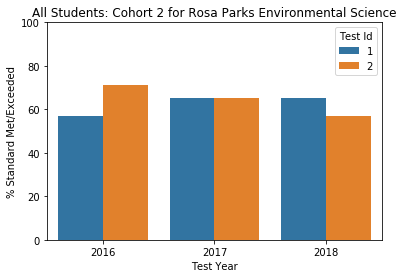

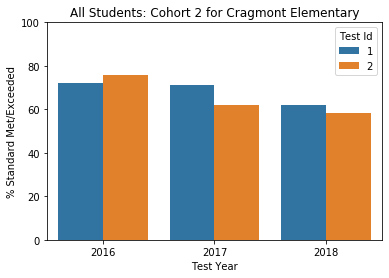

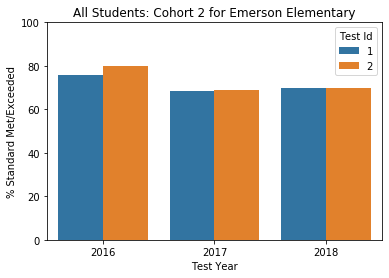

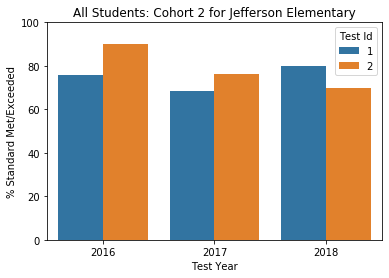

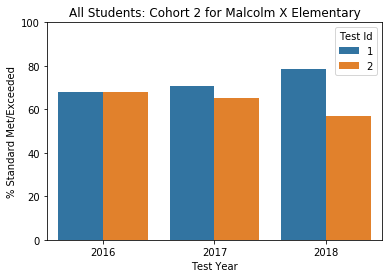

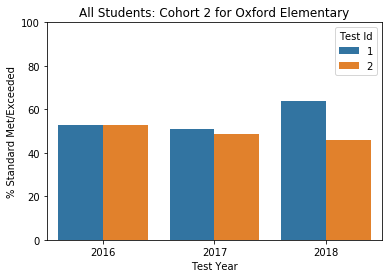

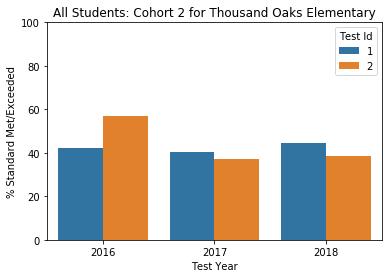

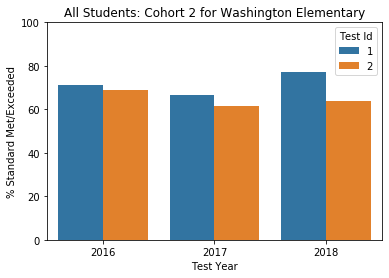

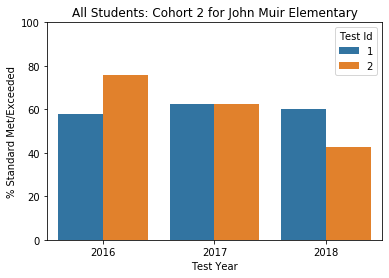

In [23]:
for s in elem_names:
    plt.figure()
    dat = elem.loc[(elem['School Name'] == s) & grp2, :]
    sns.barplot(x='Test Year', y='Met', hue='Test Id', data = dat, ci=False)
    plt.title(f'All Students: Cohort 2 for {s}')
    plt.ylabel("% Standard Met/Exceeded")
    plt.ylim(0, 100)

### 2. Cohorts by School, Test ID, Gender

In [24]:
elem_names = ['Cragmont Elementary','Emerson Elementary',
        'Jefferson Elementary','Malcolm X Elementary',
        'Oxford Elementary', 'Thousand Oaks Elementary', 'Washington Elementary',
        'John Muir Elementary', 'Rosa Parks Environmental Science']

# MALE, FEMALE STUDENTS
elem2 = df.loc[(df['School Name'].isin(elem_names)) & (df['Subgroup ID'].isin([3,4])) & (df['Grade'].isin([3,4,5])), :]
grp1 = ((elem2['Test Year']==2015)&(elem2['Grade']==3)) | ((elem2['Test Year']==2016)&(elem2['Grade']==4)) | ((elem2['Test Year']==2017)&(elem2['Grade']==5))
grp2 = ((elem2['Test Year']==2016)&(elem2['Grade']==3)) | ((elem2['Test Year']==2017)&(elem2['Grade']==4)) | ((elem2['Test Year']==2018)&(elem2['Grade']==5))


#### 2a) Cohort 1 (2015-2017) by School, Test ID, Gender

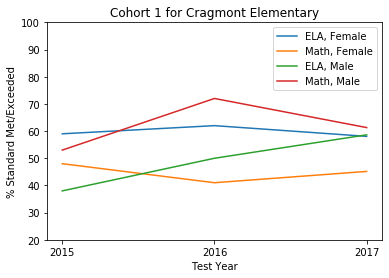

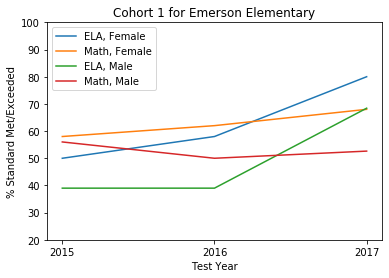

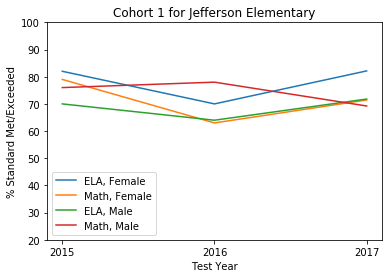

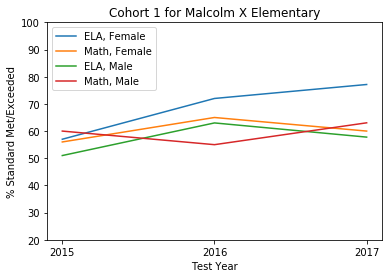

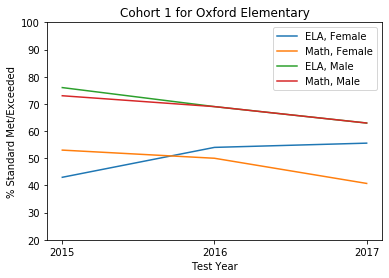

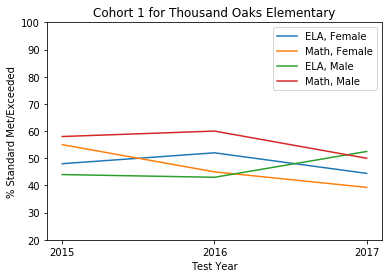

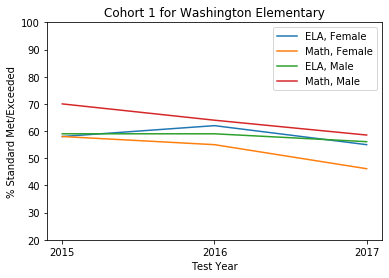

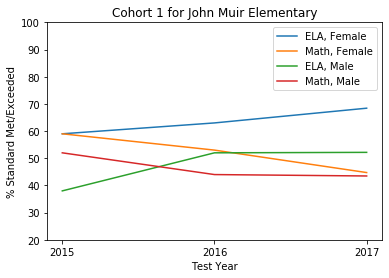

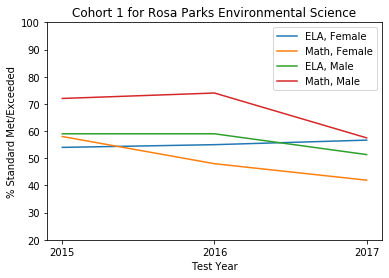

In [25]:
for s in elem_names:
    plt.figure()
    dat = elem2.loc[(elem2['School Name'] == s) & grp1, :]
    sns.lineplot(x='Test Year', y='Met', ci=False,
                 data = dat[(dat['Test Id'] == 1) & (dat['Subgroup ID'] == 4)], label="ELA, Female")
    sns.lineplot(x='Test Year', y='Met', ci=False,
                 data = dat[(dat['Test Id'] == 2) & (dat['Subgroup ID'] == 4)], label="Math, Female")
    sns.lineplot(x='Test Year', y='Met', ci=False,
                 data = dat[(dat['Test Id'] == 1) & (dat['Subgroup ID'] == 3)], label="ELA, Male")
    sns.lineplot(x='Test Year', y='Met', ci=False,
                 data = dat[(dat['Test Id'] == 2) & (dat['Subgroup ID'] == 3)], label="Math, Male")
    plt.title(f'Cohort 1 for {s}')
    plt.ylabel("% Standard Met/Exceeded")
    plt.xticks([2015, 2016, 2017])
    plt.ylim(20, 100)

#### 2b) Cohort 2 (2016-2018) by School, Test ID, Gender

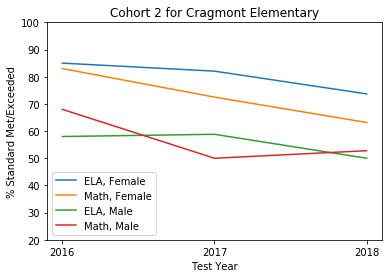

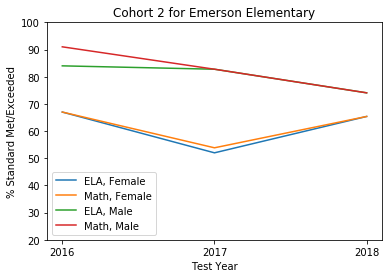

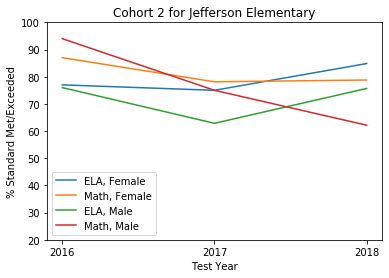

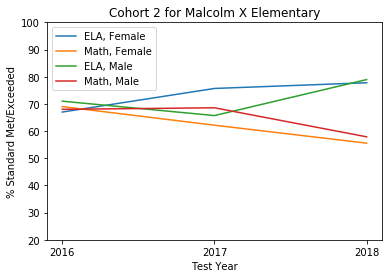

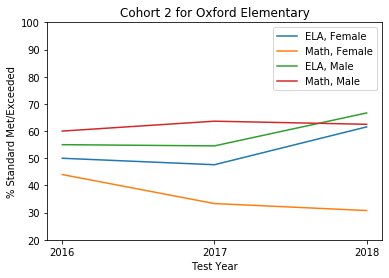

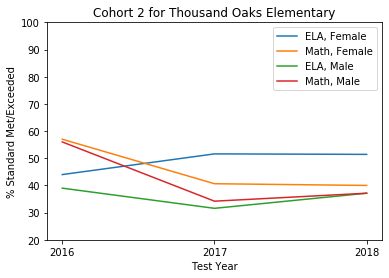

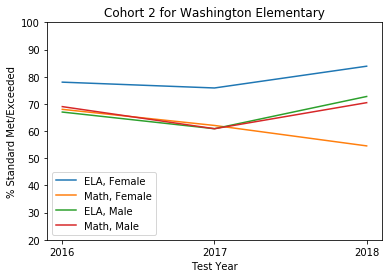

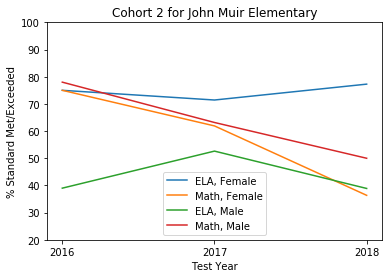

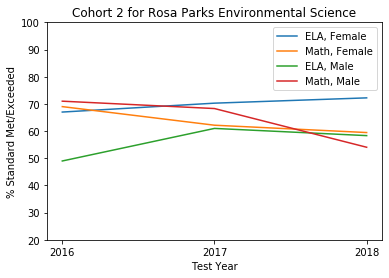

In [26]:
for s in elem_names:
    plt.figure()
    dat = elem2.loc[(elem2['School Name'] == s) & grp2, :]
    sns.lineplot(x='Test Year', y='Met', ci=False,
                 data = dat[(dat['Test Id'] == 1) & (dat['Subgroup ID'] == 4)], label="ELA, Female")
    sns.lineplot(x='Test Year', y='Met', ci=False,
                 data = dat[(dat['Test Id'] == 2) & (dat['Subgroup ID'] == 4)], label="Math, Female")
    sns.lineplot(x='Test Year', y='Met', ci=False,
                 data = dat[(dat['Test Id'] == 1) & (dat['Subgroup ID'] == 3)], label="ELA, Male")
    sns.lineplot(x='Test Year', y='Met', ci=False,
                 data = dat[(dat['Test Id'] == 2) & (dat['Subgroup ID'] == 3)], label="Math, Male")
    plt.title(f'Cohort 2 for {s}')
    plt.ylabel("% Standard Met/Exceeded")
    plt.xticks([2016, 2017, 2018])
    plt.ylim(20, 100)

### 3. Cohorts by School, Test ID, Socioeconomic Status

In [27]:
elem_names = ['Cragmont Elementary','Emerson Elementary',
        'Jefferson Elementary','Malcolm X Elementary',
        'Oxford Elementary', 'Thousand Oaks Elementary', 'Washington Elementary',
        'John Muir Elementary', 'Rosa Parks Environmental Science']

# MALE, FEMALE STUDENTS
elem3 = df.loc[(df['School Name'].isin(elem_names)) & (df['Subgroup ID'].isin([31,111])) & (df['Grade'].isin([3,4,5])), :]
grp1 = ((elem3['Test Year']==2015)&(elem3['Grade']==3)) | ((elem3['Test Year']==2016)&(elem3['Grade']==4)) | ((elem3['Test Year']==2017)&(elem3['Grade']==5))
grp2 = ((elem3['Test Year']==2016)&(elem3['Grade']==3)) | ((elem3['Test Year']==2017)&(elem3['Grade']==4)) | ((elem3['Test Year']==2018)&(elem3['Grade']==5))


#### 3a) Cohort 1 (2015-2017) by School, Test ID, Gender

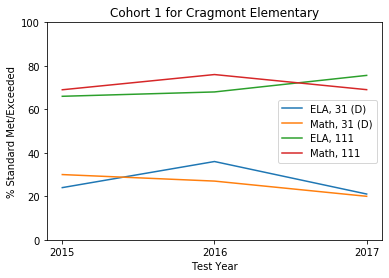

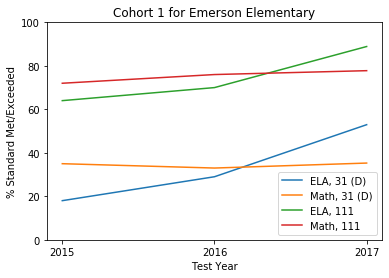

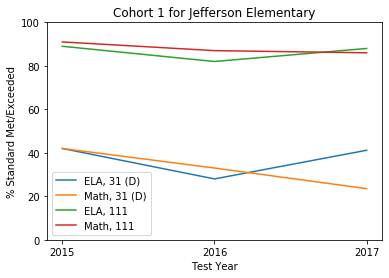

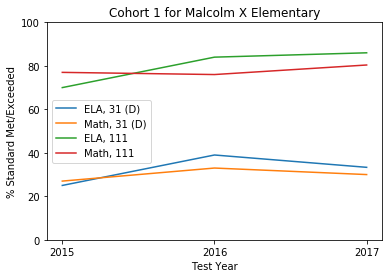

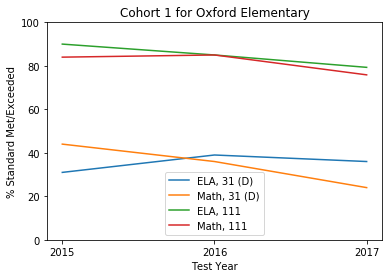

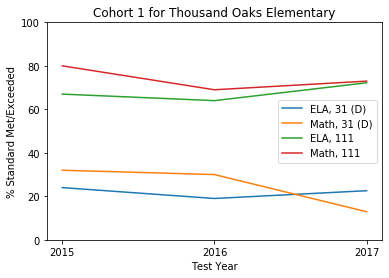

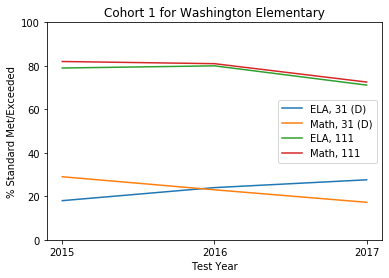

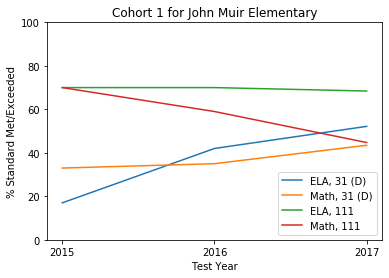

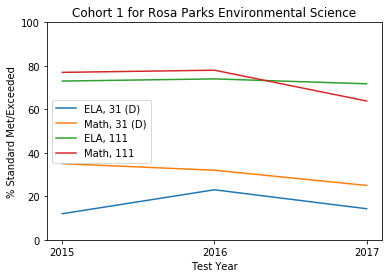

In [28]:
for s in elem_names:
    plt.figure()
    dat = elem3.loc[(elem3['School Name'] == s) & grp1, :]
    sns.lineplot(x='Test Year', y='Met', ci=False,
                 data = dat[(dat['Test Id'] == 1) & (dat['Subgroup ID'] == 31)], label="ELA, 31 (D)")
    sns.lineplot(x='Test Year', y='Met', ci=False,
                 data = dat[(dat['Test Id'] == 2) & (dat['Subgroup ID'] == 31)], label="Math, 31 (D)")
    sns.lineplot(x='Test Year', y='Met', ci=False,
                 data = dat[(dat['Test Id'] == 1) & (dat['Subgroup ID'] == 111)], label="ELA, 111")
    sns.lineplot(x='Test Year', y='Met', ci=False,
                 data = dat[(dat['Test Id'] == 2) & (dat['Subgroup ID'] == 111)], label="Math, 111")
    plt.title(f'Cohort 1 for {s}')
    plt.ylabel("% Standard Met/Exceeded")
    plt.xticks([2015, 2016, 2017])
    plt.ylim(0, 100)

#### 3b) Cohort 2 (2016-2018) by School, Test ID, Gender

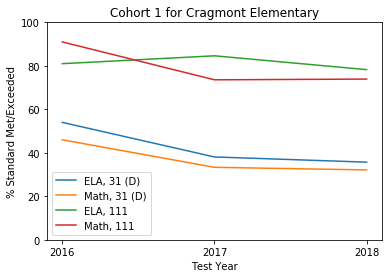

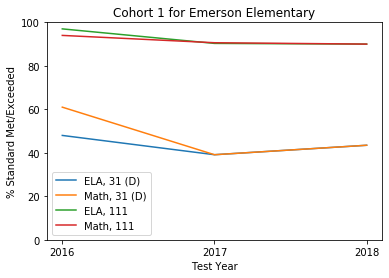

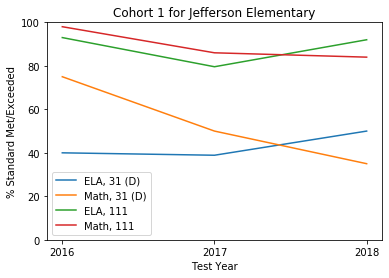

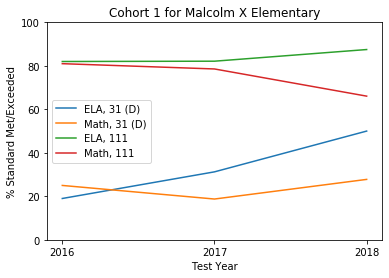

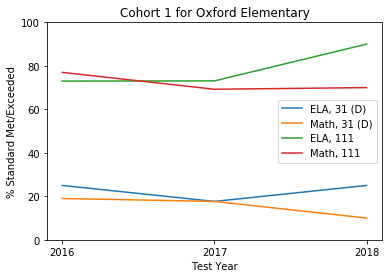

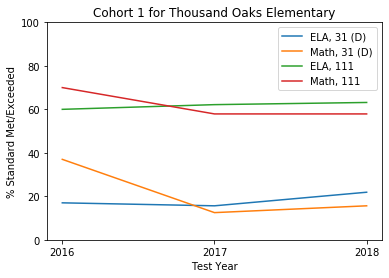

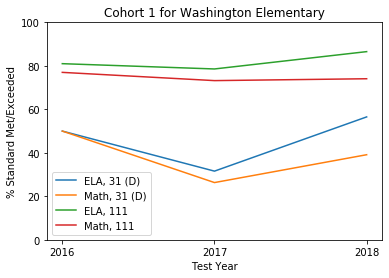

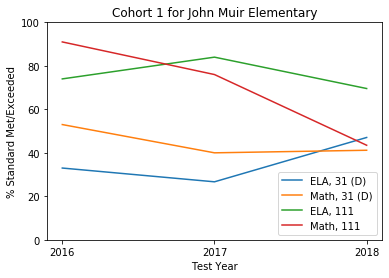

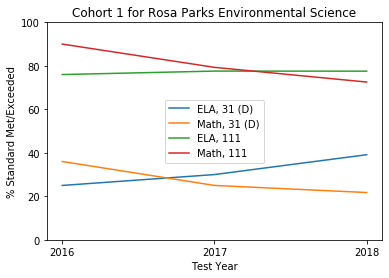

In [29]:
for s in elem_names:
    plt.figure()
    dat = elem3.loc[(elem3['School Name'] == s) & grp2, :]
    sns.lineplot(x='Test Year', y='Met', ci=False,
                 data = dat[(dat['Test Id'] == 1) & (dat['Subgroup ID'] == 31)], label="ELA, 31 (D)")
    sns.lineplot(x='Test Year', y='Met', ci=False,
                 data = dat[(dat['Test Id'] == 2) & (dat['Subgroup ID'] == 31)], label="Math, 31 (D)")
    sns.lineplot(x='Test Year', y='Met', ci=False,
                 data = dat[(dat['Test Id'] == 1) & (dat['Subgroup ID'] == 111)], label="ELA, 111")
    sns.lineplot(x='Test Year', y='Met', ci=False,
                 data = dat[(dat['Test Id'] == 2) & (dat['Subgroup ID'] == 111)], label="Math, 111")
    plt.title(f'Cohort 1 for {s}')
    plt.ylabel("% Standard Met/Exceeded")
    plt.xticks([2016, 2017, 2018])
    plt.ylim(0, 100)

### Percentage Met by Grade Level per Year

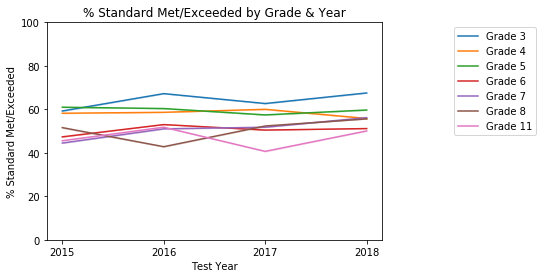

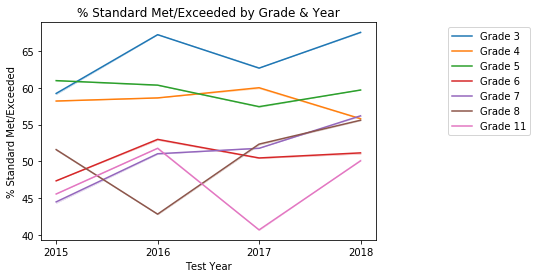

In [30]:
grades = [3, 4, 5, 6, 7, 8, 11]

for g in grades:
    sns.lineplot('Test Year', 'Met', data=df[df['Grade'] == g], ci=False, label=f'Grade {g}')
    plt.legend(bbox_to_anchor=(1.2, 1))
    plt.ylabel("% Standard Met/Exceeded")
    plt.ylim(0, 100)
    plt.title("% Standard Met/Exceeded by Grade & Year")
    plt.xticks([2015, 2016, 2017, 2018])
    
plt.figure()
for g in grades:
    sns.lineplot('Test Year', 'Met', data=df[df['Grade'] == g], ci=False, label=f'Grade {g}')
    plt.legend(bbox_to_anchor=(1.2, 1))
    plt.ylabel("% Standard Met/Exceeded")
    plt.title("% Standard Met/Exceeded by Grade & Year")
    plt.xticks([2015, 2016, 2017, 2018])

# Cohort Metrics

In [237]:
# ALL STUDENTS
elem = df.loc[(df['School Name'].isin(elem_names)) & (df['Subgroup ID'] == 1) & (df['Grade'].isin([3,4,5])), :]

# both cohorts
grp1 = ((elem['Test Year']==2015)&(elem['Grade']==3)) | ((elem['Test Year']==2016)&(elem['Grade']==4)) | ((elem['Test Year']==2017)&(elem['Grade']==5))
grp2 = ((elem['Test Year']==2016)&(elem['Grade']==3)) | ((elem['Test Year']==2017)&(elem['Grade']==4)) | ((elem['Test Year']==2018)&(elem['Grade']==5))

ch1 = elem[(grp1)]
ch2 = elem[(grp2)]

### Cohort 1: Mean Differences (All Students)

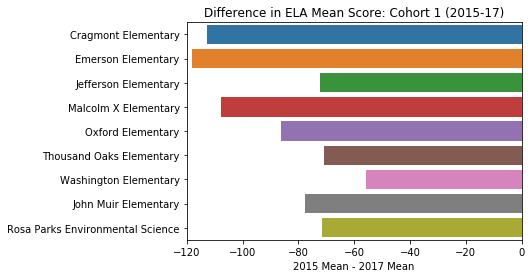

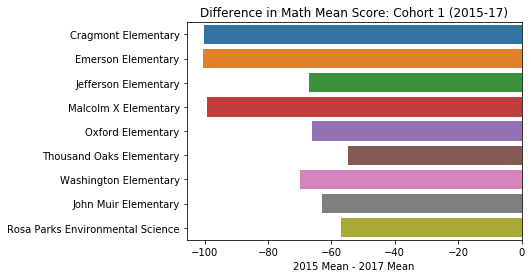

In [239]:
ch1_diff_ela, ch1_diff_math = [], []
for s in elem_names:
    f_ela = ch1.loc[(ch1['Test Year'] == 2015) & (ch1['Test Id'] == 1) & (ch1['School Name'] == s), 'Mean Scale Score']
    t_ela = ch1.loc[(ch1['Test Year'] == 2017) & (ch1['Test Id'] == 1) & (ch1['School Name'] == s), 'Mean Scale Score']
    
    f_math = ch1.loc[(ch1['Test Year'] == 2015) & (ch1['Test Id'] == 2) & (ch1['School Name'] == s), 'Mean Scale Score']
    t_math = ch1.loc[(ch1['Test Year'] == 2017) & (ch1['Test Id'] == 2) & (ch1['School Name'] == s), 'Mean Scale Score']
    
    diff_ela = float(f_ela.reset_index()['Mean Scale Score'] - t_ela.reset_index()['Mean Scale Score'])
    diff_math = float(f_math.reset_index()['Mean Scale Score'] - t_math.reset_index()['Mean Scale Score'])
    
    ch1_diff_ela.append(diff_ela)
    ch1_diff_math.append(diff_math)
    
    
sns.barplot(y=elem_names, x=ch1_diff_ela)
plt.xlabel("2015 Mean - 2017 Mean")
plt.xlim(-120, 0)
plt.title("Difference in ELA Mean Score: Cohort 1 (2015-17)")

plt.figure()

sns.barplot(y=elem_names, x=ch1_diff_math)
plt.xlabel("2015 Mean - 2017 Mean")
plt.title("Difference in Math Mean Score: Cohort 1 (2015-17)");

### Cohort 2: Mean Differences (All Students)

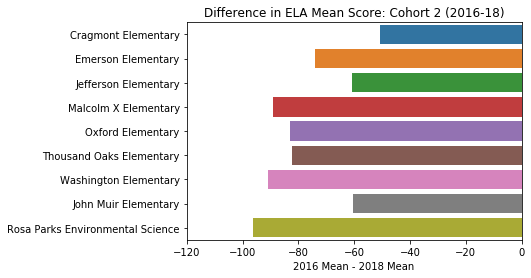

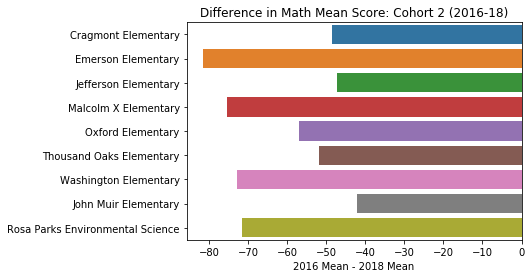

In [240]:
ch2_diff_ela, ch2_diff_math = [], []
for s in elem_names:
    f_ela = ch2.loc[(ch2['Test Year'] == 2016) & (ch2['Test Id'] == 1) & (ch2['School Name'] == s), 'Mean Scale Score']
    t_ela = ch2.loc[(ch2['Test Year'] == 2018) & (ch2['Test Id'] == 1) & (ch2['School Name'] == s), 'Mean Scale Score']
    
    f_math = ch2.loc[(ch2['Test Year'] == 2016) & (ch2['Test Id'] == 2) & (ch2['School Name'] == s), 'Mean Scale Score']
    t_math = ch2.loc[(ch2['Test Year'] == 2018) & (ch2['Test Id'] == 2) & (ch2['School Name'] == s), 'Mean Scale Score']
    
    diff_ela = float(f_ela.reset_index()['Mean Scale Score'] - t_ela.reset_index()['Mean Scale Score'])
    diff_math = float(f_math.reset_index()['Mean Scale Score'] - t_math.reset_index()['Mean Scale Score'])
    
    ch2_diff_ela.append(diff_ela)
    ch2_diff_math.append(diff_math)
    
    
sns.barplot(y=elem_names, x=ch2_diff_ela)
plt.xlabel("2016 Mean - 2018 Mean")
plt.xlim(-120, 0)
plt.title("Difference in ELA Mean Score: Cohort 2 (2016-18)")

plt.figure()

sns.barplot(y=elem_names, x=ch2_diff_math)
plt.xlabel("2016 Mean - 2018 Mean")
plt.title("Difference in Math Mean Score: Cohort 2 (2016-18)");

In [241]:
# select subgroups later
elem_sub = df.loc[(df['School Name'].isin(elem_names)) & (df['Grade'].isin([3,4,5])), :]

# both cohorts
grp1 = ((elem_sub['Test Year']==2015)&(elem_sub['Grade']==3)) | ((elem_sub['Test Year']==2016)&(elem_sub['Grade']==4)) | ((elem_sub['Test Year']==2017)&(elem_sub['Grade']==5))
grp2 = ((elem_sub['Test Year']==2016)&(elem_sub['Grade']==3)) | ((elem_sub['Test Year']==2017)&(elem_sub['Grade']==4)) | ((elem_sub['Test Year']==2018)&(elem_sub['Grade']==5))

ch1 = elem_sub[(grp1)]
ch2 = elem_sub[(grp2)]

### Cohort 1: Mean Differences (Subgroup: Gender)

In [242]:
ch1_diff_ela_gp1, ch1_diff_math_gp1 = [], []
ch1_diff_ela_gp2, ch1_diff_math_gp2 = [], []

for s in elem_names:
    ## male students
    f_ela_gp1 = ch1.loc[(ch1['Test Year'] == 2015) & (ch1['Test Id'] == 1) & (ch1['School Name'] == s) & (ch1['Subgroup ID']==3),
                    'Mean Scale Score']
    t_ela_gp1 = ch1.loc[(ch1['Test Year'] == 2017) & (ch1['Test Id'] == 1) & (ch1['School Name'] == s) & (ch1['Subgroup ID']==3),
                    'Mean Scale Score']

    f_math_gp1 = ch1.loc[(ch1['Test Year'] == 2015) & (ch1['Test Id'] == 2) & (ch1['School Name'] == s) & (ch1['Subgroup ID']==3),
                     'Mean Scale Score']
    t_math_gp1 = ch1.loc[(ch1['Test Year'] == 2017) & (ch1['Test Id'] == 2) & (ch1['School Name'] == s) & (ch1['Subgroup ID']==3),
                     'Mean Scale Score']
    
    ## female students
    f_ela_gp2 = ch1.loc[(ch1['Test Year'] == 2015) & (ch1['Test Id'] == 1) & (ch1['School Name'] == s) & (ch1['Subgroup ID']==4),
                    'Mean Scale Score']
    t_ela_gp2 = ch1.loc[(ch1['Test Year'] == 2017) & (ch1['Test Id'] == 1) & (ch1['School Name'] == s) & (ch1['Subgroup ID']==4),
                    'Mean Scale Score']
    f_math_gp2 = ch1.loc[(ch1['Test Year'] == 2015) & (ch1['Test Id'] == 2) & (ch1['School Name'] == s) & (ch1['Subgroup ID']==4),
                     'Mean Scale Score']
    t_math_gp2 = ch1.loc[(ch1['Test Year'] == 2017) & (ch1['Test Id'] == 2) & (ch1['School Name'] == s) & (ch1['Subgroup ID']==4),
                     'Mean Scale Score']
    
    
    diff_ela_gp2 = float(f_ela_gp2.reset_index()['Mean Scale Score'] - t_ela_gp2.reset_index()['Mean Scale Score'])
    diff_math_gp2 = float(f_math_gp2.reset_index()['Mean Scale Score'] - t_math_gp2.reset_index()['Mean Scale Score'])
    diff_ela_gp1 = float(f_ela_gp1.reset_index()['Mean Scale Score'] - t_ela_gp1.reset_index()['Mean Scale Score'])
    diff_math_gp1 = float(f_math_gp1.reset_index()['Mean Scale Score'] - t_math_gp1.reset_index()['Mean Scale Score'])
    
    ch1_diff_ela_gp1.append(diff_ela_gp1)
    ch1_diff_math_gp1.append(diff_math_gp1)
    ch1_diff_ela_gp2.append(diff_ela_gp2)
    ch1_diff_math_gp2.append(diff_math_gp2)

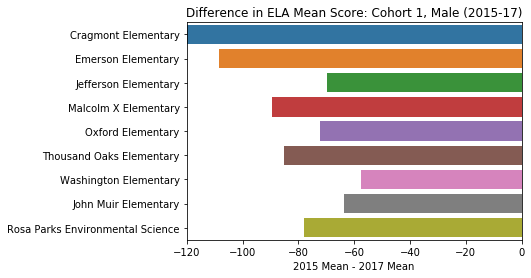

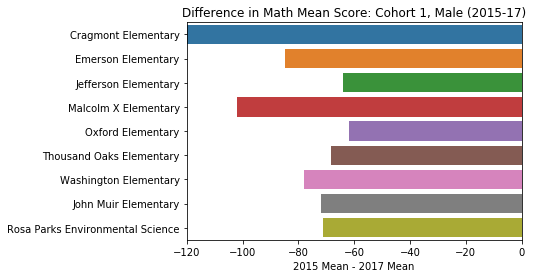

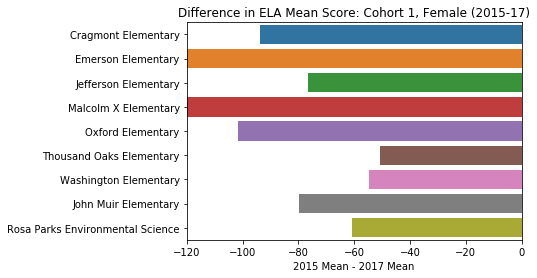

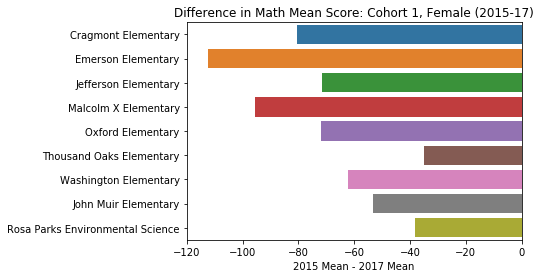

In [243]:
sns.barplot(y=elem_names, x=ch1_diff_ela_gp1)
plt.xlabel("2015 Mean - 2017 Mean")
plt.xlim(-120, 0)
plt.title("Difference in ELA Mean Score: Cohort 1, Male (2015-17)")

plt.figure()

sns.barplot(y=elem_names, x=ch1_diff_math_gp1)
plt.xlabel("2015 Mean - 2017 Mean")
plt.xlim(-120, 0)
plt.title("Difference in Math Mean Score: Cohort 1, Male (2015-17)")

plt.figure()

sns.barplot(y=elem_names, x=ch1_diff_ela_gp2)
plt.xlabel("2015 Mean - 2017 Mean")
plt.xlim(-120, 0)
plt.title("Difference in ELA Mean Score: Cohort 1, Female (2015-17)")

plt.figure()

sns.barplot(y=elem_names, x=ch1_diff_math_gp2)
plt.xlabel("2015 Mean - 2017 Mean")
plt.xlim(-120, 0)
plt.title("Difference in Math Mean Score: Cohort 1, Female (2015-17)");

### Cohort 2: Mean Differences (Subgroup: Gender)

In [244]:
ch2_diff_ela_gp1, ch2_diff_math_gp1 = [], []
ch2_diff_ela_gp2, ch2_diff_math_gp2 = [], []

for s in elem_names:
    ## male students
    f_ela_gp1 = ch2.loc[(ch2['Test Year'] == 2016) & (ch2['Test Id'] == 1) & (ch2['School Name'] == s) & (ch2['Subgroup ID']==3),
                    'Mean Scale Score']
    t_ela_gp1 = ch2.loc[(ch2['Test Year'] == 2018) & (ch2['Test Id'] == 1) & (ch2['School Name'] == s) & (ch2['Subgroup ID']==3),
                    'Mean Scale Score']

    f_math_gp1 = ch2.loc[(ch2['Test Year'] == 2016) & (ch2['Test Id'] == 2) & (ch2['School Name'] == s) & (ch2['Subgroup ID']==3),
                     'Mean Scale Score']
    t_math_gp1 = ch2.loc[(ch2['Test Year'] == 2018) & (ch2['Test Id'] == 2) & (ch2['School Name'] == s) & (ch2['Subgroup ID']==3),
                     'Mean Scale Score']
    
    ## female students
    f_ela_gp2 = ch2.loc[(ch2['Test Year'] == 2016) & (ch2['Test Id'] == 1) & (ch2['School Name'] == s) & (ch2['Subgroup ID']==4),
                    'Mean Scale Score']
    t_ela_gp2 = ch2.loc[(ch2['Test Year'] == 2018) & (ch2['Test Id'] == 1) & (ch2['School Name'] == s) & (ch2['Subgroup ID']==4),
                    'Mean Scale Score']
    f_math_gp2 = ch2.loc[(ch2['Test Year'] == 2016) & (ch2['Test Id'] == 2) & (ch2['School Name'] == s) & (ch2['Subgroup ID']==4),
                     'Mean Scale Score']
    t_math_gp2 = ch2.loc[(ch2['Test Year'] == 2018) & (ch2['Test Id'] == 2) & (ch2['School Name'] == s) & (ch2['Subgroup ID']==4),
                     'Mean Scale Score']
    
    
    diff_ela_gp2 = float(f_ela_gp2.reset_index()['Mean Scale Score'] - t_ela_gp2.reset_index()['Mean Scale Score'])
    diff_math_gp2 = float(f_math_gp2.reset_index()['Mean Scale Score'] - t_math_gp2.reset_index()['Mean Scale Score'])
    diff_ela_gp1 = float(f_ela_gp1.reset_index()['Mean Scale Score'] - t_ela_gp1.reset_index()['Mean Scale Score'])
    diff_math_gp1 = float(f_math_gp1.reset_index()['Mean Scale Score'] - t_math_gp1.reset_index()['Mean Scale Score'])
    
    ch2_diff_ela_gp1.append(diff_ela_gp1)
    ch2_diff_math_gp1.append(diff_math_gp1)
    ch2_diff_ela_gp2.append(diff_ela_gp2)
    ch2_diff_math_gp2.append(diff_math_gp2)

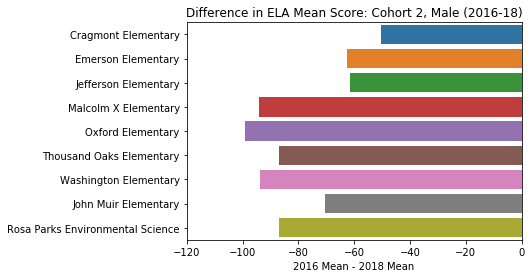

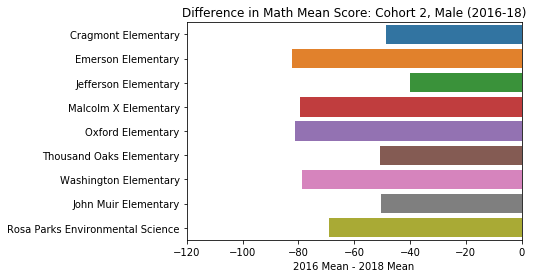

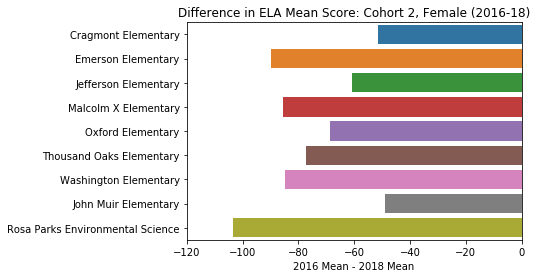

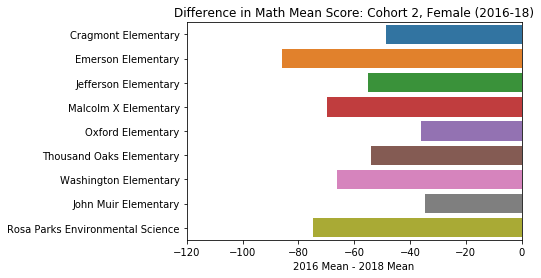

In [245]:
sns.barplot(y=elem_names, x=ch2_diff_ela_gp1)
plt.xlabel("2016 Mean - 2018 Mean")
plt.xlim(-120, 0)
plt.title("Difference in ELA Mean Score: Cohort 2, Male (2016-18)")

plt.figure()

sns.barplot(y=elem_names, x=ch2_diff_math_gp1)
plt.xlabel("2016 Mean - 2018 Mean")
plt.xlim(-120, 0)
plt.title("Difference in Math Mean Score: Cohort 2, Male (2016-18)")

plt.figure()

sns.barplot(y=elem_names, x=ch2_diff_ela_gp2)
plt.xlabel("2016 Mean - 2018 Mean")
plt.xlim(-120, 0)
plt.title("Difference in ELA Mean Score: Cohort 2, Female (2016-18)")

plt.figure()

sns.barplot(y=elem_names, x=ch2_diff_math_gp2)
plt.xlabel("2016 Mean - 2018 Mean")
plt.xlim(-120, 0)
plt.title("Difference in Math Mean Score: Cohort 2, Female (2016-18)");

### Cohort 1: Mean Differences (Subgroup: Economic)

In [246]:
ch1_diff_ela_gp1, ch1_diff_math_gp1 = [], []
ch1_diff_ela_gp2, ch1_diff_math_gp2 = [], []

for s in elem_names:
    ## male students
    f_ela_gp1 = ch1.loc[(ch1['Test Year'] == 2015) & (ch1['Test Id'] == 1) & (ch1['School Name'] == s) & (ch1['Subgroup ID']==31),
                    'Mean Scale Score']
    t_ela_gp1 = ch1.loc[(ch1['Test Year'] == 2017) & (ch1['Test Id'] == 1) & (ch1['School Name'] == s) & (ch1['Subgroup ID']==31),
                    'Mean Scale Score']

    f_math_gp1 = ch1.loc[(ch1['Test Year'] == 2015) & (ch1['Test Id'] == 2) & (ch1['School Name'] == s) & (ch1['Subgroup ID']==31),
                     'Mean Scale Score']
    t_math_gp1 = ch1.loc[(ch1['Test Year'] == 2017) & (ch1['Test Id'] == 2) & (ch1['School Name'] == s) & (ch1['Subgroup ID']==31),
                     'Mean Scale Score']
    
    ## female students
    f_ela_gp2 = ch1.loc[(ch1['Test Year'] == 2015) & (ch1['Test Id'] == 1) & (ch1['School Name'] == s) & (ch1['Subgroup ID']==111),
                    'Mean Scale Score']
    t_ela_gp2 = ch1.loc[(ch1['Test Year'] == 2017) & (ch1['Test Id'] == 1) & (ch1['School Name'] == s) & (ch1['Subgroup ID']==111),
                    'Mean Scale Score']
    f_math_gp2 = ch1.loc[(ch1['Test Year'] == 2015) & (ch1['Test Id'] == 2) & (ch1['School Name'] == s) & (ch1['Subgroup ID']==111),
                     'Mean Scale Score']
    t_math_gp2 = ch1.loc[(ch1['Test Year'] == 2017) & (ch1['Test Id'] == 2) & (ch1['School Name'] == s) & (ch1['Subgroup ID']==111),
                     'Mean Scale Score']
    
    
    diff_ela_gp2 = float(f_ela_gp2.reset_index()['Mean Scale Score'] - t_ela_gp2.reset_index()['Mean Scale Score'])
    diff_math_gp2 = float(f_math_gp2.reset_index()['Mean Scale Score'] - t_math_gp2.reset_index()['Mean Scale Score'])
    diff_ela_gp1 = float(f_ela_gp1.reset_index()['Mean Scale Score'] - t_ela_gp1.reset_index()['Mean Scale Score'])
    diff_math_gp1 = float(f_math_gp1.reset_index()['Mean Scale Score'] - t_math_gp1.reset_index()['Mean Scale Score'])
    
    ch1_diff_ela_gp1.append(diff_ela_gp1)
    ch1_diff_math_gp1.append(diff_math_gp1)
    ch1_diff_ela_gp2.append(diff_ela_gp2)
    ch1_diff_math_gp2.append(diff_math_gp2)

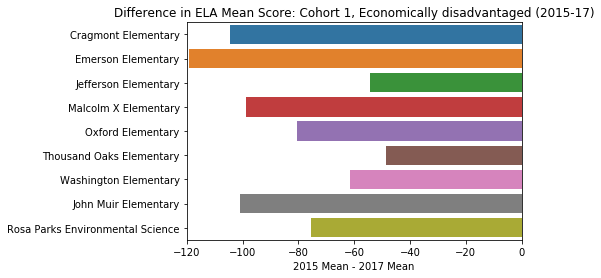

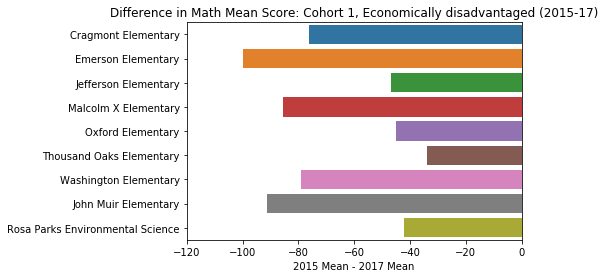

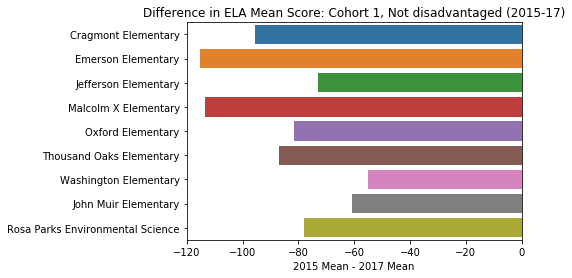

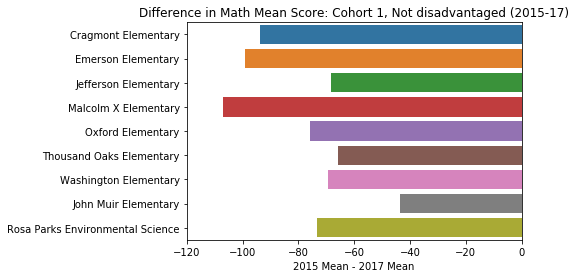

In [247]:
sns.barplot(y=elem_names, x=ch1_diff_ela_gp1)
plt.xlabel("2015 Mean - 2017 Mean")
plt.xlim(-120, 0)
plt.title("Difference in ELA Mean Score: Cohort 1, Economically disadvantaged (2015-17)")

plt.figure()

sns.barplot(y=elem_names, x=ch1_diff_math_gp1)
plt.xlabel("2015 Mean - 2017 Mean")
plt.xlim(-120, 0)
plt.title("Difference in Math Mean Score: Cohort 1, Economically disadvantaged (2015-17)")

plt.figure()

sns.barplot(y=elem_names, x=ch1_diff_ela_gp2)
plt.xlabel("2015 Mean - 2017 Mean")
plt.xlim(-120, 0)
plt.title("Difference in ELA Mean Score: Cohort 1, Not disadvantaged (2015-17)")

plt.figure()

sns.barplot(y=elem_names, x=ch1_diff_math_gp2)
plt.xlabel("2015 Mean - 2017 Mean")
plt.xlim(-120, 0)
plt.title("Difference in Math Mean Score: Cohort 1, Not disadvantaged (2015-17)");

### Cohort 2: Mean Differences (Subgroup: Economic)

In [248]:
ch2_diff_ela_gp1, ch2_diff_math_gp1 = [], []
ch2_diff_ela_gp2, ch2_diff_math_gp2 = [], []

for s in elem_names:
    ## male students
    f_ela_gp1 = ch2.loc[(ch2['Test Year'] == 2016) & (ch2['Test Id'] == 1) & (ch2['School Name'] == s) & (ch2['Subgroup ID']==31),
                    'Mean Scale Score']
    t_ela_gp1 = ch2.loc[(ch2['Test Year'] == 2018) & (ch2['Test Id'] == 1) & (ch2['School Name'] == s) & (ch2['Subgroup ID']==31),
                    'Mean Scale Score']

    f_math_gp1 = ch2.loc[(ch2['Test Year'] == 2016) & (ch2['Test Id'] == 2) & (ch2['School Name'] == s) & (ch2['Subgroup ID']==31),
                     'Mean Scale Score']
    t_math_gp1 = ch2.loc[(ch2['Test Year'] == 2018) & (ch2['Test Id'] == 2) & (ch2['School Name'] == s) & (ch2['Subgroup ID']==31),
                     'Mean Scale Score']
    
    ## female students
    f_ela_gp2 = ch2.loc[(ch2['Test Year'] == 2016) & (ch2['Test Id'] == 1) & (ch2['School Name'] == s) & (ch2['Subgroup ID']==111),
                    'Mean Scale Score']
    t_ela_gp2 = ch2.loc[(ch2['Test Year'] == 2018) & (ch2['Test Id'] == 1) & (ch2['School Name'] == s) & (ch2['Subgroup ID']==111),
                    'Mean Scale Score']
    f_math_gp2 = ch2.loc[(ch2['Test Year'] == 2016) & (ch2['Test Id'] == 2) & (ch2['School Name'] == s) & (ch2['Subgroup ID']==111),
                     'Mean Scale Score']
    t_math_gp2 = ch2.loc[(ch2['Test Year'] == 2018) & (ch2['Test Id'] == 2) & (ch2['School Name'] == s) & (ch2['Subgroup ID']==111),
                     'Mean Scale Score']
    
    
    diff_ela_gp2 = float(f_ela_gp2.reset_index()['Mean Scale Score'] - t_ela_gp2.reset_index()['Mean Scale Score'])
    diff_math_gp2 = float(f_math_gp2.reset_index()['Mean Scale Score'] - t_math_gp2.reset_index()['Mean Scale Score'])
    diff_ela_gp1 = float(f_ela_gp1.reset_index()['Mean Scale Score'] - t_ela_gp1.reset_index()['Mean Scale Score'])
    diff_math_gp1 = float(f_math_gp1.reset_index()['Mean Scale Score'] - t_math_gp1.reset_index()['Mean Scale Score'])
    
    ch2_diff_ela_gp1.append(diff_ela_gp1)
    ch2_diff_math_gp1.append(diff_math_gp1)
    ch2_diff_ela_gp2.append(diff_ela_gp2)
    ch2_diff_math_gp2.append(diff_math_gp2)

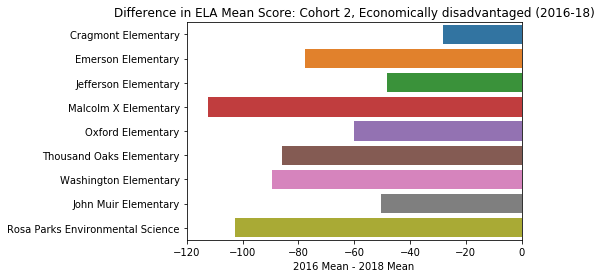

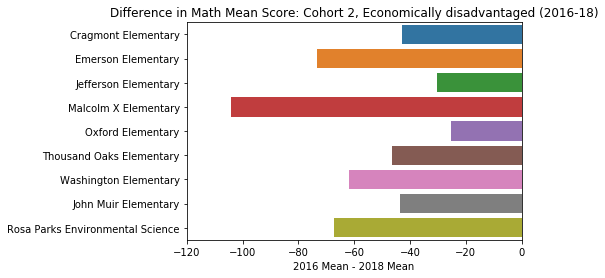

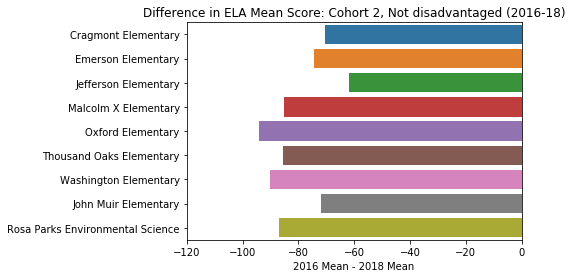

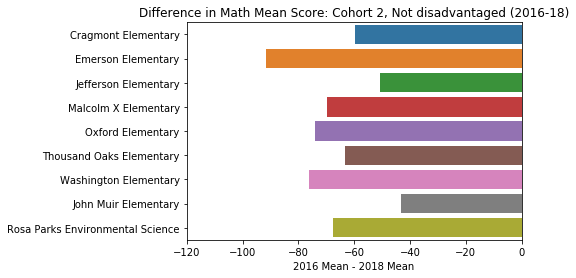

In [249]:
sns.barplot(y=elem_names, x=ch2_diff_ela_gp1)
plt.xlabel("2016 Mean - 2018 Mean")
plt.xlim(-120, 0)
plt.title("Difference in ELA Mean Score: Cohort 2, Economically disadvantaged (2016-18)")

plt.figure()

sns.barplot(y=elem_names, x=ch2_diff_math_gp1)
plt.xlabel("2016 Mean - 2018 Mean")
plt.xlim(-120, 0)
plt.title("Difference in Math Mean Score: Cohort 2, Economically disadvantaged (2016-18)")

plt.figure()

sns.barplot(y=elem_names, x=ch2_diff_ela_gp2)
plt.xlabel("2016 Mean - 2018 Mean")
plt.xlim(-120, 0)
plt.title("Difference in ELA Mean Score: Cohort 2, Not disadvantaged (2016-18)")

plt.figure()

sns.barplot(y=elem_names, x=ch2_diff_math_gp2)
plt.xlabel("2016 Mean - 2018 Mean")
plt.xlim(-120, 0)
plt.title("Difference in Math Mean Score: Cohort 2, Not disadvantaged (2016-18)");

# Explanatory Variables

In [10]:
# read in datasets
staff = pd.read_csv("data/vars/staffbyeth.txt", sep="	")
staff['White Not Hispanic'] = pd.to_numeric(staff['White Not Hispanic'], errors='coerce')
staff['Total'] = pd.to_numeric(staff['Total'], errors='coerce')

In [11]:
staff['non_white'] = 100 - ((staff['White Not Hispanic']/staff['Total']) * 100)
keep_schools = ['Berkeley High', 'Cragmont Elementary', 'Emerson Elementary', 'Jefferson Elementary',
               'John Muir Elementary', 'Longfellow Arts And Technology Middle', 'Malcolm X Elementary',
               'Martin Luther King Middle', 'Oxford Elementary', 'Rosa Parks Environmental Science',
               'Sylvia Mendez Elementary', 'Thousand Oaks Elementary', 'Washington Elementary', 'Willard Middle',
               'Berkeley Arts Magnet At Whittier']

staff_df = staff.loc[staff['Name'].isin(keep_schools), :]
staff_df.head()

,Name,Code,Hispanic,American Indian or Alaska Native,Asian Not Hispanic,Pacific Islander Not Hispanic,Filipino Not Hispanic,African American Not Hispanic,White Not Hispanic,Two or More Races Not Hispanic,No Response,Total,non_white
0,Berkeley Arts Magnet At Whittier,6097729,1,0,3,0,0,3,23.0,1,0,31.0,25.806452
1,Berkeley High,131177,17,1,12,0,4,10,138.0,6,3,191.0,27.748691
3,Cragmont Elementary,6090195,4,0,0,1,1,1,22.0,1,1,31.0,29.032258
5,Emerson Elementary,6090211,3,0,2,0,1,1,16.0,1,2,26.0,38.461538
6,Jefferson Elementary,6090252,2,0,1,0,0,3,21.0,0,3,30.0,30.000000


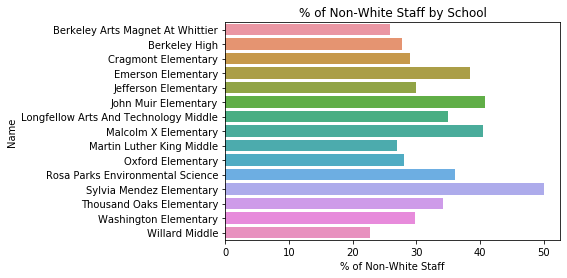

In [12]:
sns.barplot(x='non_white', y='Name', data=staff_df)
plt.xlabel("% of Non-White Staff")
plt.title("% of Non-White Staff by School");

In [13]:
staff_18 = dat_18.merge(staff_df, left_on = 'School Name', right_on = 'Name')

all_scores_ela = staff_18.loc[(staff_18['Subgroup ID']==1) & (staff_18['Test Id']==1) & (staff_18['Grade']!=13), :]
all_scores_math = staff_18.loc[(staff_18['Subgroup ID']==1) & (staff_18['Test Id']==2) & (staff_18['Grade']!=13), :]

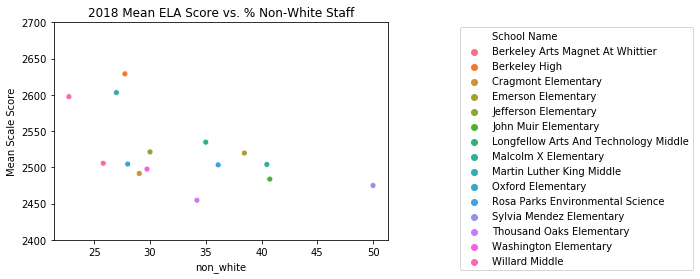

In [14]:
sns.scatterplot(x='non_white', y='Mean Scale Score', data=all_scores_ela.groupby('School Name').mean(),
               hue = all_scores_ela.groupby('School Name').mean().index)
plt.legend(bbox_to_anchor=(1.2, 1))
plt.ylim(2400, 2700)
plt.title("2018 Mean ELA Score vs. % Non-White Staff");

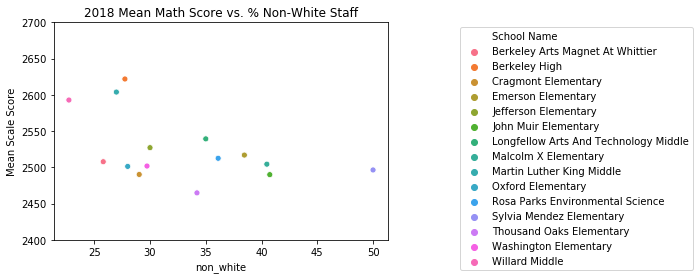

In [15]:
sns.scatterplot(x='non_white', y='Mean Scale Score', data=all_scores_math.groupby('School Name').mean(),
               hue = all_scores_math.groupby('School Name').mean().index)
plt.legend(bbox_to_anchor=(1.2, 1))
plt.ylim(2400, 2700)
plt.title("2018 Mean Math Score vs. % Non-White Staff");

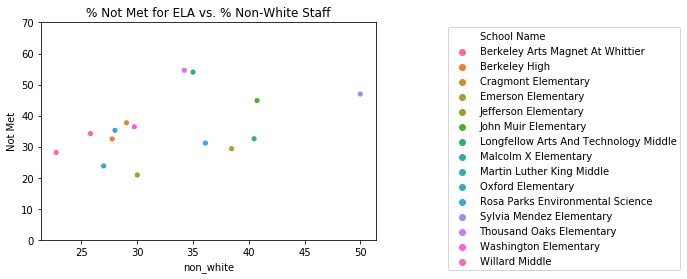

In [16]:
sns.scatterplot(x='non_white', y='Not Met', data=all_scores_ela.groupby('School Name').mean(),
               hue = all_scores_ela.groupby('School Name').mean().index)
plt.legend(bbox_to_anchor=(1.2, 1))
plt.ylim(0, 70)
plt.title("% Not Met for ELA vs. % Non-White Staff");

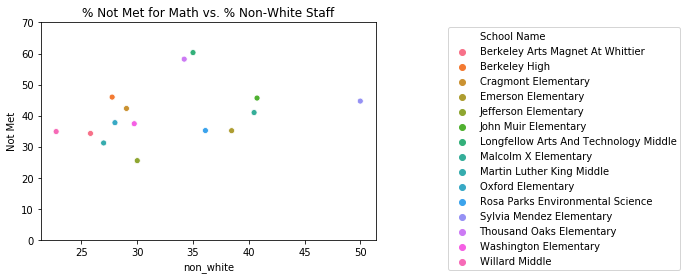

In [17]:
sns.scatterplot(x='non_white', y='Not Met', data=all_scores_math.groupby('School Name').mean(),
               hue = all_scores_math.groupby('School Name').mean().index)
plt.legend(bbox_to_anchor=(1.2, 1))
plt.ylim(0, 70)
plt.title("% Not Met for Math vs. % Non-White Staff");